In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from functools import wraps
import numpy as np
from scipy.stats import poisson as _poisson

In [2]:
# Funções copiadas para gerar distribuição de poisson de forma mais eficiente
def cache_on_instance(func):
    """caching for single argument methods"""
    @wraps(func)
    def wrapper(instance, n):
        cache = getattr(instance, "{}_cache".format(func.__name__))
        if n not in cache:
            output = func(instance, n)
            cache[n] = output
            return output
        else:
            return func(instance, n)
    return wrapper

class Poisson:
    """Caching Poisson Distribution"""
    def __init__(self, mean):
        self.mean = mean

        self.pmf_cache = dict()
        self.cdf_cache = dict()

    @cache_on_instance
    def pmf(self, n):
        return np.exp(- self.mean) * np.power(self.mean, n) / np.math.factorial(n)
        # return _poisson.pmf(n, self.mean)

    @cache_on_instance
    def cdf(self, n):
        return _poisson.cdf(n, self.mean)

class Distributions:
    def __init__(self):
        self.x_rental = Poisson(3)
        self.x_return = Poisson(3)
        self.y_rental = Poisson(4)
        self.y_return = Poisson(2)

In [3]:
class Environment:
    def __init__(self, distribution: Distributions, max_cars: int, rent_reward: int, move_cost: int, max_move: int, discounting: float):
        """
        :param distribution: Objeto contendo as distribuições probabilísticas dos retornos e aluguéis.
        :param max_cars: Número máximo de carros em cada local.
        :param rent_reward: Recompensa por cada carro alugado.
        :param move_cost: Custo para movimentar um carro de uma posição para a outra (negativo).
        :param max_move: Número máximo de carros que podem ser movidos de uma localização para outra.
        :param discounting: Parâmetro de desconto utilizado para calcular retorno esperado.
        """
        self.discounting = discounting
        self.max_move = max_move
        self.distribution = distribution
        self.max_cars = max_cars
        self.rent_reward = rent_reward
        self.move_cost = move_cost

    def possible_states(self) -> np.ndarray:
        """
        Retorna um array numpy todos os estados possíveis, cada estado em formato de tupla, onde a primeira posição é a quantidade de carros na posição 1, e a segunda é a quantidade de carros na posição 2.
        :return: np.ndarray contendo todos os estados possíveis.
        """
        states = []
        for i in range(self.max_cars+1):
            for j in range(self.max_cars+1):
                states.append((i, j))
        return np.array(states)

    def possible_actions(self, states: tuple) -> np.ndarray:
        """
        Retorna todas as ações possíveis, dado um estado.
        :param states: Estado na qual se quer obter as ações possíveis.
        :return: np.ndarray contendo todas as ações possíveis, representadas por um inteiro.
        """
        cars1, cars2 = states
        max_action = min(cars1, self.max_move)
        min_action = -1*min(cars2, self.max_move)
        return np.array([i for i in range(min_action, max_action + 1)])

    def expected_return(self, state: tuple, action: int, values: np.ndarray) -> float:
        """
        Retorna o retorno esperado de uma ação, dado um estado, e os valores esperados atuais.
        :param state: Estado na qual é realizada a ação.
        :param action: Ação realizada.
        :param values: np.ndarray contendo todos os valores esperados atuais.
        :return: Valor esperado para este estado.
        """
        # inicializamos o retorno, como o custo de movimentar sempre aparece na recompensa, podemos o somar diretamente, já que o somatório das probabilidades sempre será 1 (lembre p(s', r | s, a)).
        returns = abs(action) * self.move_cost
        cars_loc1, cars_loc2 = state
        # realizamos a ação sobre os carros, como o estado representa quantidade de carros no fim do dia, sendo realizada a movimentação durante a noite, precisamos aplicá-la antes de iniciar as vendas e retornos.
        cars_loc1 = min(cars_loc1 - action, self.max_cars)
        cars_loc2 = min(cars_loc2 + action, self.max_cars)
        # Iteramos sobre 0 a 11, sendo cada número a quantidade de clientes que aparecem no local 1 e 2 respectivamente.
        # Foi escolhido o intervalo 0 a 11, pois, ao se visualizar as distribuições de poisson nos valores do problema, é possível perceber que acima de 10, a probabilidade fica muito pequena, tornando desnecessário a sua inclusão, que apenas aumenta o tempo de processamento.
        for rent_loc1 in range(0, 11):
            for rent_loc2 in range(0, 11):
                # probabilidade da quantidade rent_loc1 e rent_loc2 de clientes aparecerem, é dada pela distribuição de poisson, que podemos utilizar o objeto da classe Distributions para calcular:
                rent_prob = self.distribution.x_rental.pmf(rent_loc1) * self.distribution.y_rental.pmf(rent_loc2)
                # a quantidade de carros alugados será o mínimo entre a quantidade de clientes, e a quantidade de carros, já que não podemos alugar mais carros do que temos.
                rent1 = min(cars_loc1, rent_loc1)
                rent2 = min(cars_loc2, rent_loc2)
                rewards = (rent1 + rent2) * self.rent_reward
                # agora iteramos novamente sobre 0 e 11, sendo cada número a quantidade de carros que foram retornados, note que como os carros retornados só se tornam alugáveis no próximo estado, eles não precisam entrar na conta dos aluguéis.
                for return_loc1 in range(0, 11):
                    for return_loc2 in range(0, 11):
                        # novamente calculamos as probabilidades desta quantidade de carros serem retornados
                        returns_prob = self.distribution.x_return.pmf(return_loc1) * self.distribution.y_return.pmf(return_loc2)
                        # a quantidade de carros do próximo estado, será a quantidade de carros em cada uma das localizações, menos a quantidade de carros alugados, mais a quantidade de carros retornados
                        cars1_ns = int(min(cars_loc1 - rent1 + return_loc1, self.max_cars))
                        cars2_ns = int(min(cars_loc2 - rent2 + return_loc2, self.max_cars))
                        # somamos, conforme o livro, as probabilidades (p(s', r | s, a)) multiplicado pela recompensa, mais o valor anterior descontado (r + γ*V(s'))
                        returns += returns_prob * rent_prob * (rewards + self.discounting * values[cars1_ns, cars2_ns])
        return returns

def evaluate_policy(env: Environment, values: np.ndarray, policy: np.ndarray) -> float:
    """
    Dado um array contendo todos os valores anteriores, um ambiente e uma policy, atualiza estes valores utilizando as ações dadas pela policy, ou seja, realiza policy_evaluation
    :param env: Ambiente no qual se passa o problema
    :param values: array contendo valores esperados
    :param policy: policy
    :return: valor delta indicando a maior diferença entre um estado novo e um antigo
    """
    delta = 0
    # para todos os estados no ambiente
    for state in env.possible_states():
        state = tuple(state)
        prev = values[state]
        # atualizamos o valor esperado deste estado, utilizando a ação dada pela policy
        values[state] = env.expected_return(state, policy[state], values)
        delta = max(delta, abs(prev - values[state]))
    return delta

def improve_policy(env: Environment, values: np.ndarray, policy:np.ndarray) -> np.ndarray:
    """
    Realiza policy improvement, para cada estado do ambiente, calculamos os valores esperados para cada ação que possa ser realizada neste estado, utilizando os valores esperados já obtidos, presumidamente, por policy evaluation, e em seguida atualizamos a Policy gulosamente para realizar a ação que maximiza o retorno esperado
    :param env: Ambiente no qual se passa o problema
    :param values: array contendo valores esperados
    :param policy: policy antiga
    :return: nova policy atualizada
    """
    new = np.zeros(policy.shape)
    for state in env.possible_states():
        vdict = {}
        state = tuple(state)
        # para cada ação possível em um estado
        for action in env.possible_actions(state):
            # calculamos o seu valor esperado, e guardamos em um dicionário, onde a chave é a ação, e os valores são os valores esperados
            vdict[action] = env.expected_return(state, action, values)
        # a ação com maior valor é atribuída para a policy
        new[state] = max(vdict, key=vdict.get)
    return new

def policy_stable(old: np.ndarray, new: np.ndarray) -> bool:
    """
    Verifica se duas policies são iguais, caso sejam, a policy está estável
    :param old: policy antiga
    :param new: policy nova
    :return: true caso sejam iguais
    """
    return np.array_equal(old, new)

def iterate(env: Environment, values: np.ndarray, policy: np.ndarray, theta: float) -> np.ndarray:
    """
    Realiza uma policy iteration, isto é, realizamos policy evaluation, até a função valor esperado convergir, neste caso, a diferença máxima entre um valor esperado novo e um velho ser menor que theta, e em seguida realiza policy improvement.
    :param env: Ambiente no qual se passa o problema
    :param values: array contendo valores esperados
    :param policy: Policy a ser utilizada durante policy evaluation
    :param theta: Parâmetro de convergência
    :return: policy nova
    """
    while True:
        delta = evaluate_policy(env, values, policy)
        print(f"Delta: {delta}, Theta: {theta}")
        if delta < theta:
            break
    print("Improving policy ...")
    new = improve_policy(env, values, policy)
    if policy_stable(policy, new):
        return new
    return new


In [4]:
env = Environment(Distributions(), 20, 10, -2, 5, 0.9)
values = np.zeros((21, 21))
policy = np.zeros((21, 21))
ideal_p = iterate(env, values, policy, 0.01)

Delta: 191.1404442545006, Theta: 0.01
Delta: 131.91909180411537, Theta: 0.01
Delta: 88.61937127296494, Theta: 0.01
Delta: 66.27613430095823, Theta: 0.01
Delta: 52.304040346176976, Theta: 0.01
Delta: 40.50431282688419, Theta: 0.01
Delta: 31.571819689709855, Theta: 0.01
Delta: 25.009002907688227, Theta: 0.01
Delta: 20.776212359973727, Theta: 0.01
Delta: 17.373214856382276, Theta: 0.01
Delta: 14.489145965680791, Theta: 0.01
Delta: 12.054381189472394, Theta: 0.01
Delta: 10.005913044444071, Theta: 0.01
Delta: 8.28806058889046, Theta: 0.01
Delta: 6.85197859667943, Theta: 0.01
Delta: 5.654991085770405, Theta: 0.01
Delta: 4.6599910305831145, Theta: 0.01
Delta: 3.8349060091838965, Theta: 0.01
Delta: 3.152195244708878, Theta: 0.01
Delta: 2.588360954112204, Theta: 0.01
Delta: 2.1234741080099298, Theta: 0.01
Delta: 1.7407223622979586, Theta: 0.01
Delta: 1.4259887280389307, Theta: 0.01
Delta: 1.1674672474201202, Theta: 0.01
Delta: 0.9553189041118912, Theta: 0.01
Delta: 0.7813683111010619, Theta: 0.

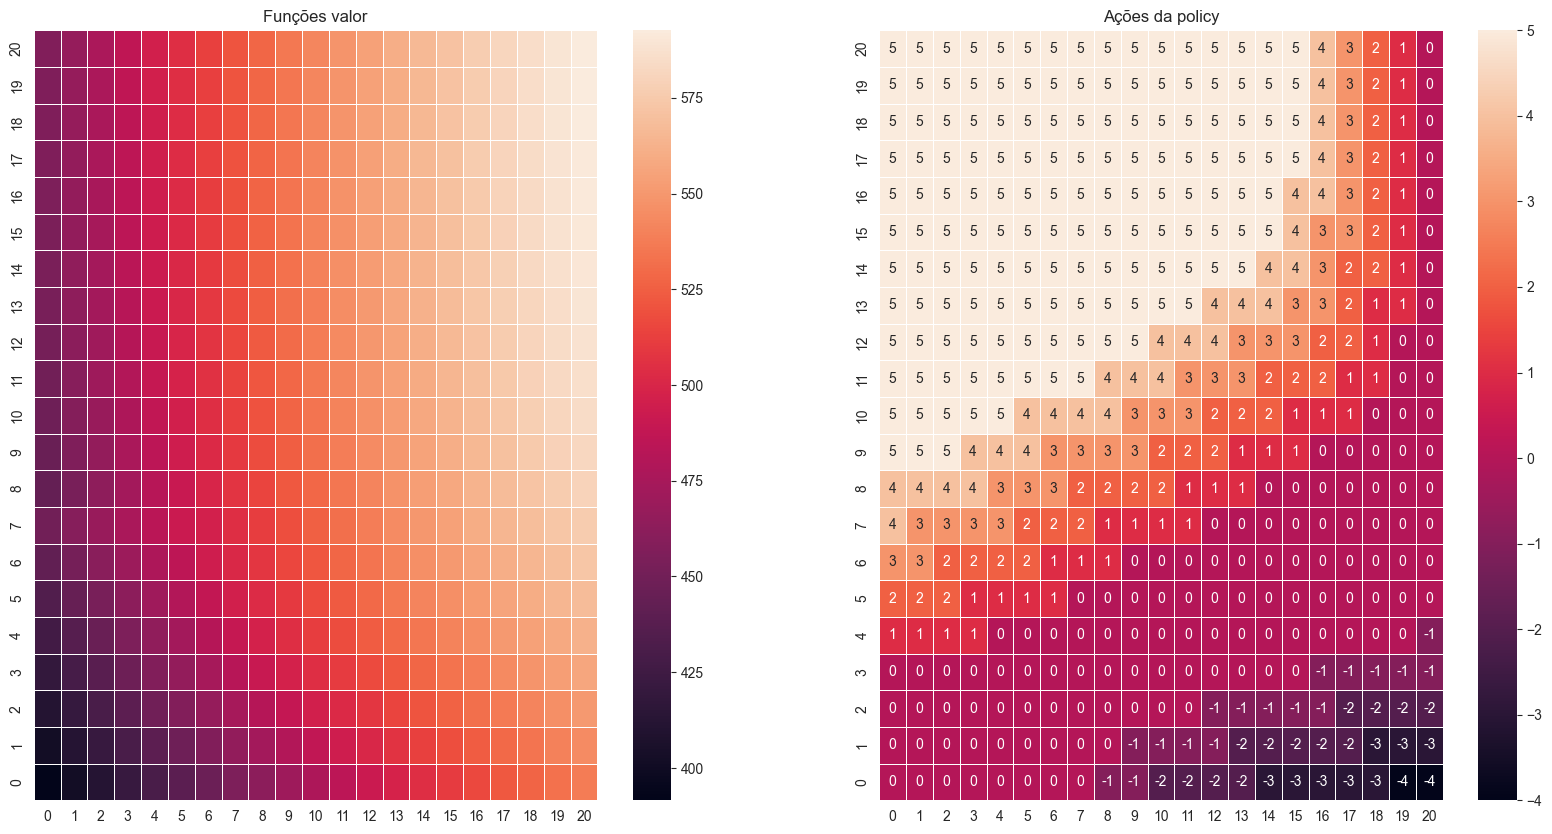

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(values, linewidths=0.5, ax=ax1)
ax1.set_title("Funções valor")
ax1.invert_yaxis()

sns.heatmap(ideal_p, linewidths=0.5, annot=True, ax=ax2)
ax2.set_title("Ações da policy")
ax2.invert_yaxis()


In [10]:
ideal_p = iterate(env, values, ideal_p, 0.01)

Delta: 64.47075172081264, Theta: 0.01
Delta: 4.491073659461108, Theta: 0.01
Delta: 2.0552618841732055, Theta: 0.01
Delta: 1.4115428721905232, Theta: 0.01
Delta: 1.1929974023295244, Theta: 0.01
Delta: 0.962509967309984, Theta: 0.01
Delta: 0.7886196682625268, Theta: 0.01
Delta: 0.6437201336383396, Theta: 0.01
Delta: 0.524514525178688, Theta: 0.01
Delta: 0.4270193908441797, Theta: 0.01
Delta: 0.3474874224721134, Theta: 0.01
Delta: 0.2826946667407242, Theta: 0.01
Delta: 0.22994781268391762, Theta: 0.01
Delta: 0.18702521172735942, Theta: 0.01
Delta: 0.152105716034157, Theta: 0.01
Delta: 0.12370142193947231, Theta: 0.01
Delta: 0.10059893465324876, Theta: 0.01
Delta: 0.0818097841320764, Theta: 0.01
Delta: 0.06652924989464282, Theta: 0.01
Delta: 0.05410246362066573, Theta: 0.01
Delta: 0.043996637532870864, Theta: 0.01
Delta: 0.03577837552359142, Theta: 0.01
Delta: 0.0290951681512297, Theta: 0.01
Delta: 0.023660315767017437, Theta: 0.01
Delta: 0.01924065295526134, Theta: 0.01
Delta: 0.015646557

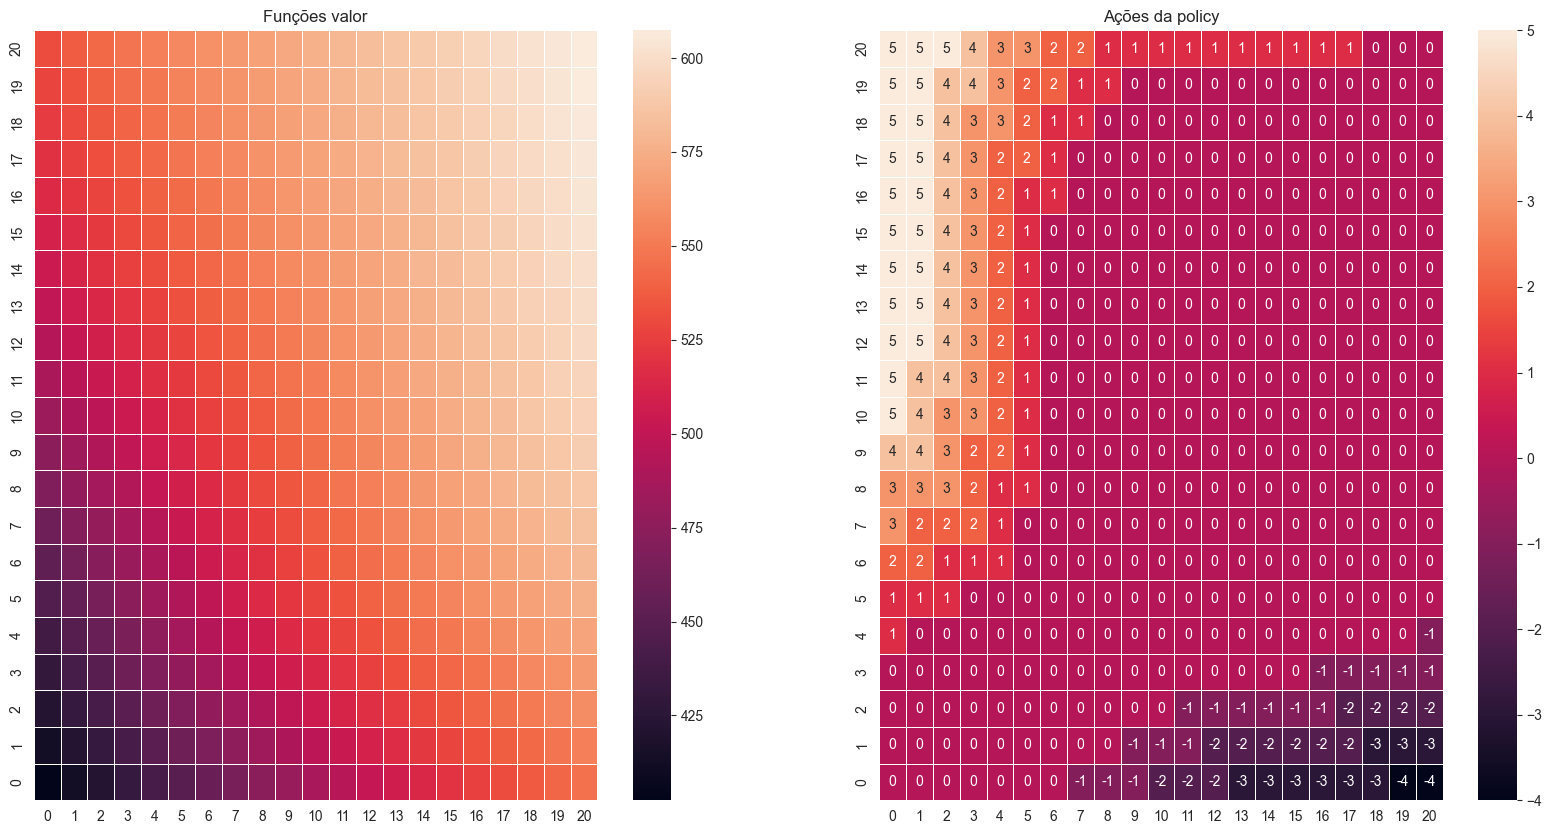

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(values, linewidths=0.5, ax=ax1)
ax1.set_title("Funções valor")
ax1.invert_yaxis()

sns.heatmap(ideal_p, linewidths=0.5, annot=True, ax=ax2)
ax2.set_title("Ações da policy")
ax2.invert_yaxis()

In [12]:
ideal_p = iterate(env, values, ideal_p, 0.01)

Delta: 4.205488783998476, Theta: 0.01
Delta: 2.80101341167142, Theta: 0.01
Delta: 1.8951679674711386, Theta: 0.01
Delta: 1.3533212494605777, Theta: 0.01
Delta: 0.9235220392189376, Theta: 0.01
Delta: 0.6122362190333206, Theta: 0.01
Delta: 0.40414382295807627, Theta: 0.01
Delta: 0.2708767619772061, Theta: 0.01
Delta: 0.19514745059359484, Theta: 0.01
Delta: 0.14774452488745737, Theta: 0.01
Delta: 0.11503218228074275, Theta: 0.01
Delta: 0.09395140490460108, Theta: 0.01
Delta: 0.07663581623347682, Theta: 0.01
Delta: 0.06246070071347276, Theta: 0.01
Delta: 0.05088096575292411, Theta: 0.01
Delta: 0.04143409478547255, Theta: 0.01
Delta: 0.03373385355666869, Theta: 0.01
Delta: 0.027460777650105683, Theta: 0.01
Delta: 0.02235218189321131, Theta: 0.01
Delta: 0.01819286591216951, Theta: 0.01
Delta: 0.014806944174381442, Theta: 0.01
Delta: 0.012050879710955087, Theta: 0.01
Delta: 0.0098076481747853, Theta: 0.01
Improving policy ...


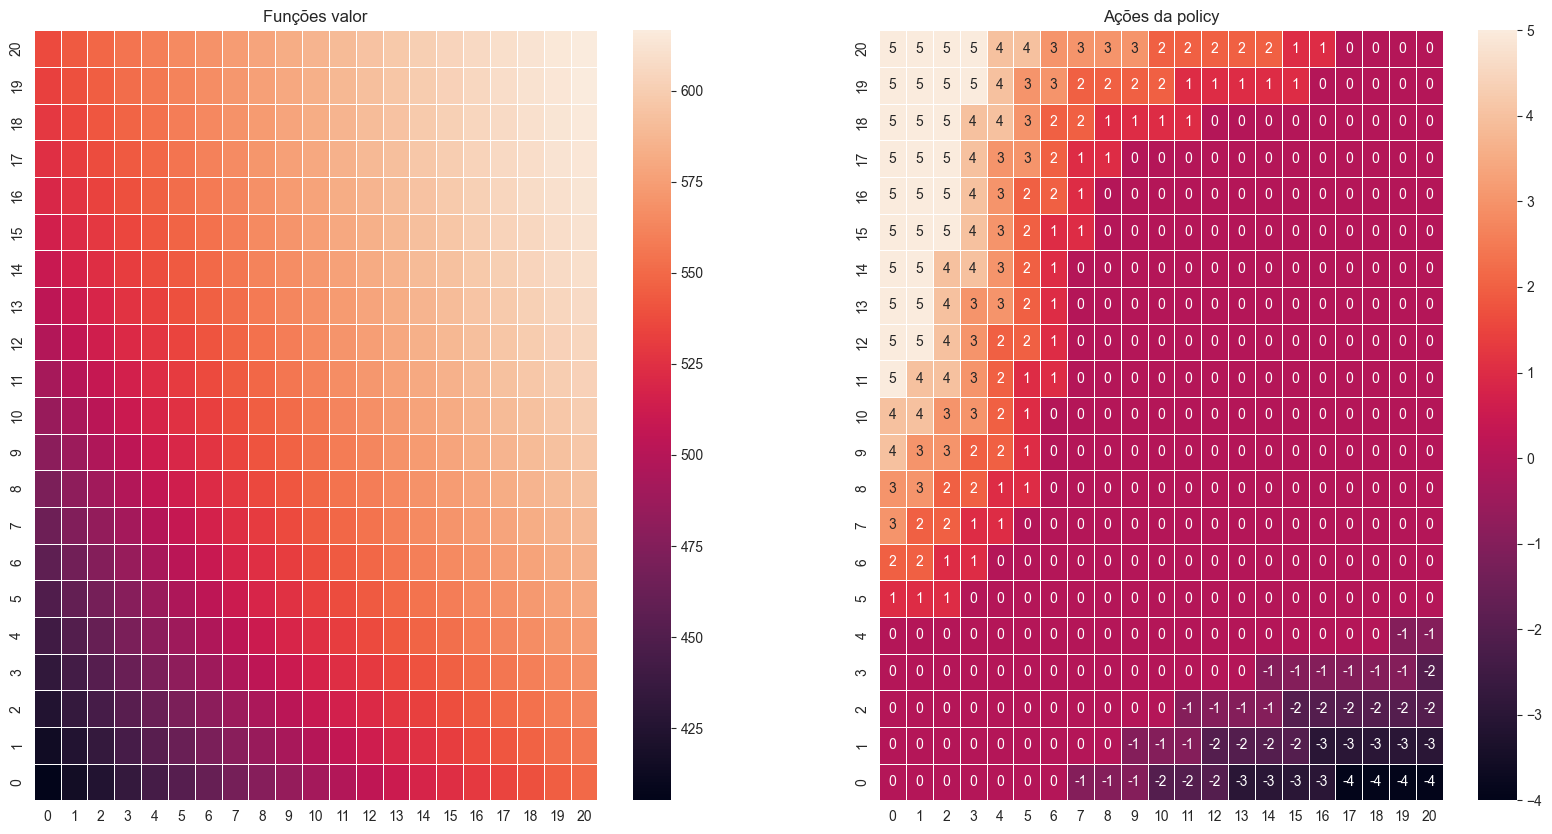

In [13]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(values, linewidths=0.5, ax=ax1)
ax1.set_title("Funções valor")
ax1.invert_yaxis()

sns.heatmap(ideal_p, linewidths=0.5, annot=True, ax=ax2)
ax2.set_title("Ações da policy")
ax2.invert_yaxis()

In [45]:
class Modified(Environment):
    # Modificando para resolver o problema alternativo
    def expected_return(self, state: tuple, action: int, values: np.ndarray) -> float:
        # Caso a ação seja maior ou igual a 1, ou seja, estamos movendo um carro de 1 para 2, um dos carros é movido de graça
        if action >= 1:
            returns = (action - 1) * self.move_cost
        else:
            returns = abs(action) * self.move_cost
        cars_loc1, cars_loc2 = state
        cars_loc1 = min(cars_loc1 - action, self.max_cars)
        cars_loc2 = min(cars_loc2 + action, self.max_cars)
        # caso a localização 1 tenha mais de 10 carros, devemos reduzir os retornos em -4 (preço do estacionamento)
        if cars_loc1 > 10:
            returns -= 4
        # caso a localização 2 tenha mais de 10 carros, devemos reduzir os retornos em -4 (preço do estacionamento)
        if cars_loc2 > 10:
            returns -= 4
        # o resto do algoritmo é feito como anteriormente.
        for rent_loc1 in range(0, 11):
            for rent_loc2 in range(0, 11):
                rent_prob = self.distribution.x_rental.pmf(rent_loc1) * self.distribution.y_rental.pmf(rent_loc2)
                rent1 = min(cars_loc1, rent_loc1)
                rent2 = min(cars_loc2, rent_loc2)
                rewards = (rent1 + rent2) * self.rent_reward
                for return_loc1 in range(0, 11):
                    for return_loc2 in range(0, 11):
                        returns_prob = self.distribution.x_return.pmf(return_loc1) * self.distribution.y_return.pmf(return_loc2)
                        cars1_ns = int(min(cars_loc1 - rent1 + return_loc1, self.max_cars))
                        cars2_ns = int(min(cars_loc1 - rent1 + return_loc1, self.max_cars))
                        returns += returns_prob * rent_prob * (rewards + self.discounting * values[cars1_ns, cars2_ns])
        return returns

In [46]:
env = Modified(Distributions(), 20, 10, -2, 5, 0.9)
values = np.zeros((21, 21))
policy = np.zeros((21, 21))
ideal_p = iterate(env, values, policy, 0.01)

Delta: 120.47957477798658, Theta: 0.01
Delta: 83.25225778358997, Theta: 0.01
Delta: 68.74359715303899, Theta: 0.01
Delta: 57.37051233030732, Theta: 0.01
Delta: 47.95092864567471, Theta: 0.01
Delta: 42.101986917754516, Theta: 0.01
Delta: 36.443063938735065, Theta: 0.01
Delta: 31.28903268125123, Theta: 0.01
Delta: 26.7282071438878, Theta: 0.01
Delta: 22.75483768022451, Theta: 0.01
Delta: 19.32536268794803, Theta: 0.01
Delta: 16.383087202350623, Theta: 0.01
Delta: 13.869231103521997, Theta: 0.01
Delta: 11.727849714266142, Theta: 0.01
Delta: 9.907885419256843, Theta: 0.01
Delta: 8.363832912346595, Theta: 0.01
Delta: 7.055727366566487, Theta: 0.01
Delta: 5.948810348117945, Theta: 0.01
Delta: 5.013056700066784, Theta: 0.01
Delta: 4.222658389048377, Theta: 0.01
Delta: 3.5555152222927404, Theta: 0.01
Delta: 2.9927573413701225, Theta: 0.01
Delta: 2.51831063776865, Theta: 0.01
Delta: 2.1185086511995905, Theta: 0.01
Delta: 1.78175039507488, Theta: 0.01
Delta: 1.4982014121887914, Theta: 0.01
Delta

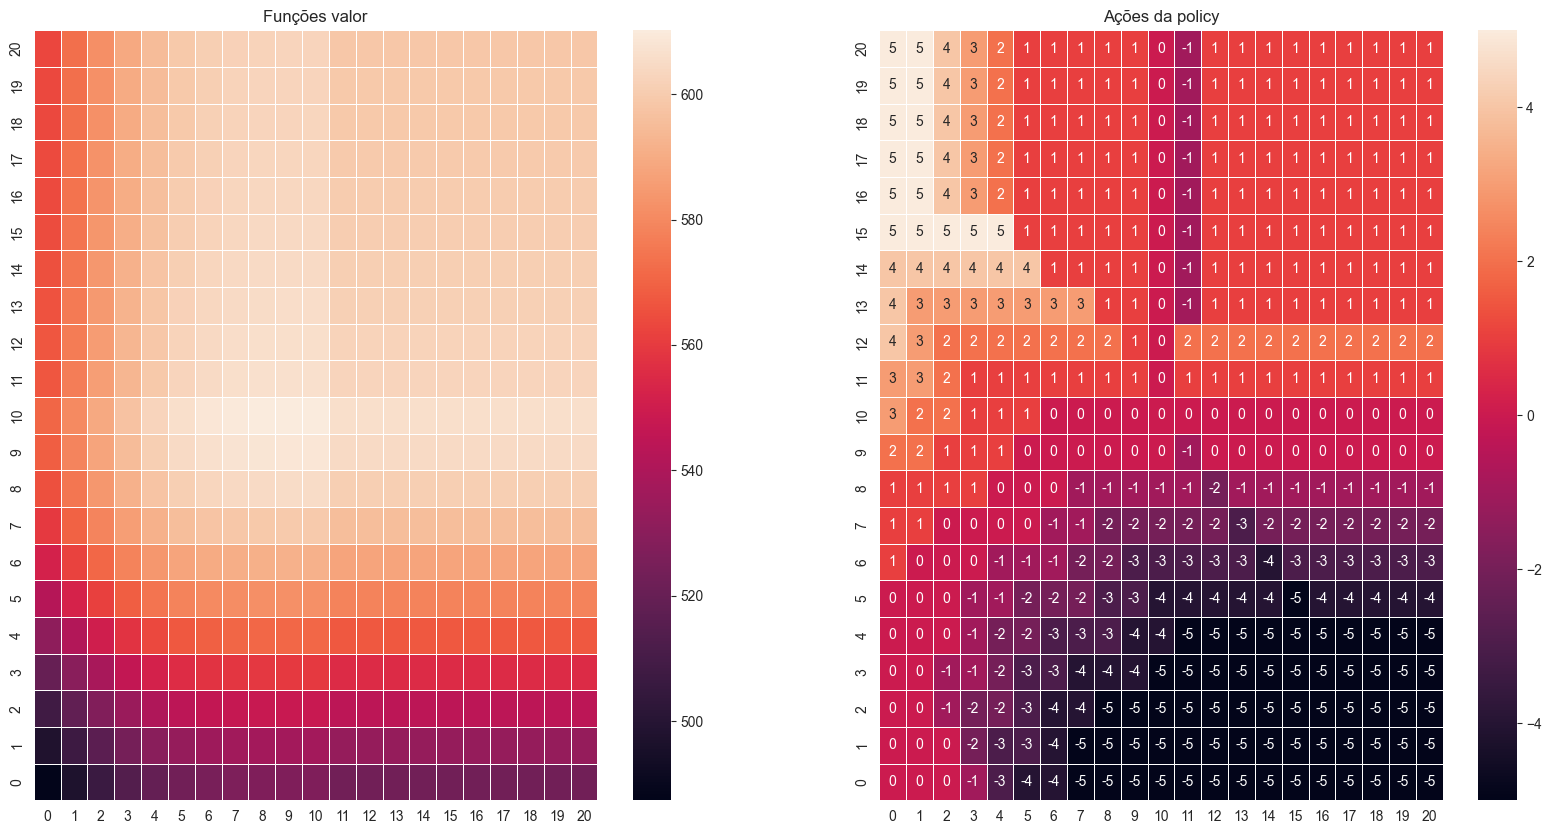

In [47]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(values, linewidths=0.5, ax=ax1)
ax1.set_title("Funções valor")
ax1.invert_yaxis()

sns.heatmap(ideal_p, linewidths=0.5, annot=True, ax=ax2)
ax2.set_title("Ações da policy")
ax2.invert_yaxis()

In [48]:
ideal_p = iterate(env, values, ideal_p, 0.01)

Delta: 49.08994937766954, Theta: 0.01
Delta: 2.915648894378023, Theta: 0.01
Delta: 2.265834903101563, Theta: 0.01
Delta: 1.9339857404530676, Theta: 0.01
Delta: 1.602180932212093, Theta: 0.01
Delta: 1.3252571082080067, Theta: 0.01
Delta: 1.0996119387605177, Theta: 0.01
Delta: 0.9123700939352375, Theta: 0.01
Delta: 0.756357505965525, Theta: 0.01
Delta: 0.6267422743059115, Theta: 0.01
Delta: 0.5193606379132234, Theta: 0.01
Delta: 0.43050579638457975, Theta: 0.01
Delta: 0.35698504153828026, Theta: 0.01
Delta: 0.2961229550933808, Theta: 0.01
Delta: 0.24570850052015203, Theta: 0.01
Delta: 0.2039235137103219, Theta: 0.01
Delta: 0.1692737283540282, Theta: 0.01
Delta: 0.1405295425781219, Theta: 0.01
Delta: 0.11667736994252209, Theta: 0.01
Delta: 0.09688027907498054, Theta: 0.01
Delta: 0.08044621960812037, Theta: 0.01
Delta: 0.0668022964172792, Theta: 0.01
Delta: 0.055473846015502204, Theta: 0.01
Delta: 0.04606734122813805, Theta: 0.01
Delta: 0.03825636848631575, Theta: 0.01
Delta: 0.03177008923

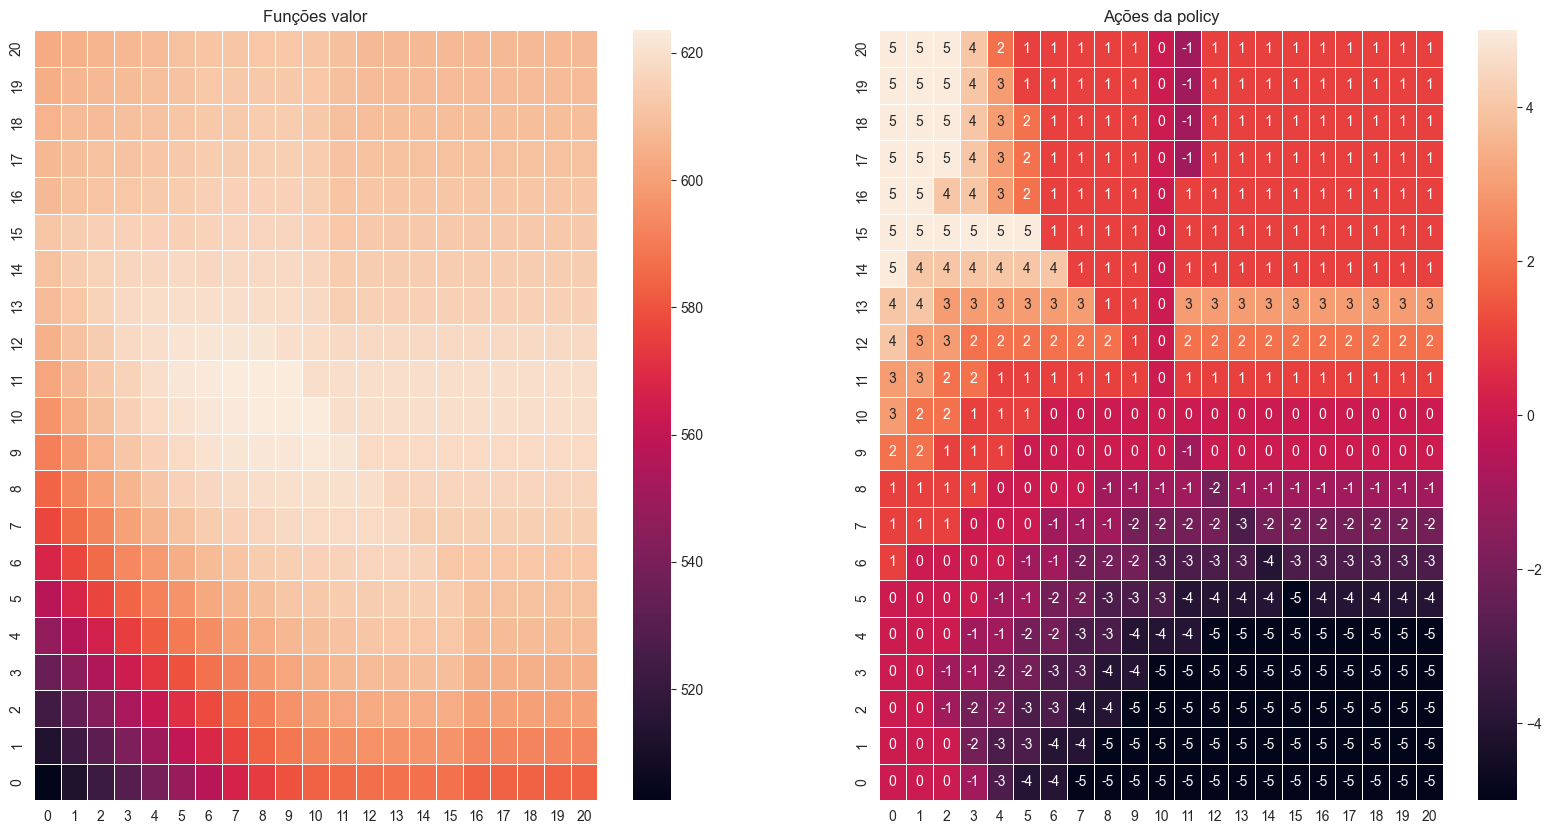

In [49]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(values, linewidths=0.5, ax=ax1)
ax1.set_title("Funções valor")
ax1.invert_yaxis()

sns.heatmap(ideal_p, linewidths=0.5, annot=True, ax=ax2)
ax2.set_title("Ações da policy")
ax2.invert_yaxis()

In [50]:
ideal_p = iterate(env, values, ideal_p, 0.01)

Delta: 1.0816907887001435, Theta: 0.01
Delta: 0.17669102378454227, Theta: 0.01
Delta: 0.11430387281063759, Theta: 0.01
Delta: 0.08908659190973367, Theta: 0.01
Delta: 0.0688695327207256, Theta: 0.01
Delta: 0.055890669074983634, Theta: 0.01
Delta: 0.04670885685828807, Theta: 0.01
Delta: 0.03928456521350654, Theta: 0.01
Delta: 0.03296733881404634, Theta: 0.01
Delta: 0.02757459882980129, Theta: 0.01
Delta: 0.023008502414541, Theta: 0.01
Delta: 0.01917075302299054, Theta: 0.01
Delta: 0.015960329550466668, Theta: 0.01
Delta: 0.013281861196105638, Theta: 0.01
Delta: 0.011050428537544121, Theta: 0.01
Delta: 0.009192834151008356, Theta: 0.01
Improving policy ...


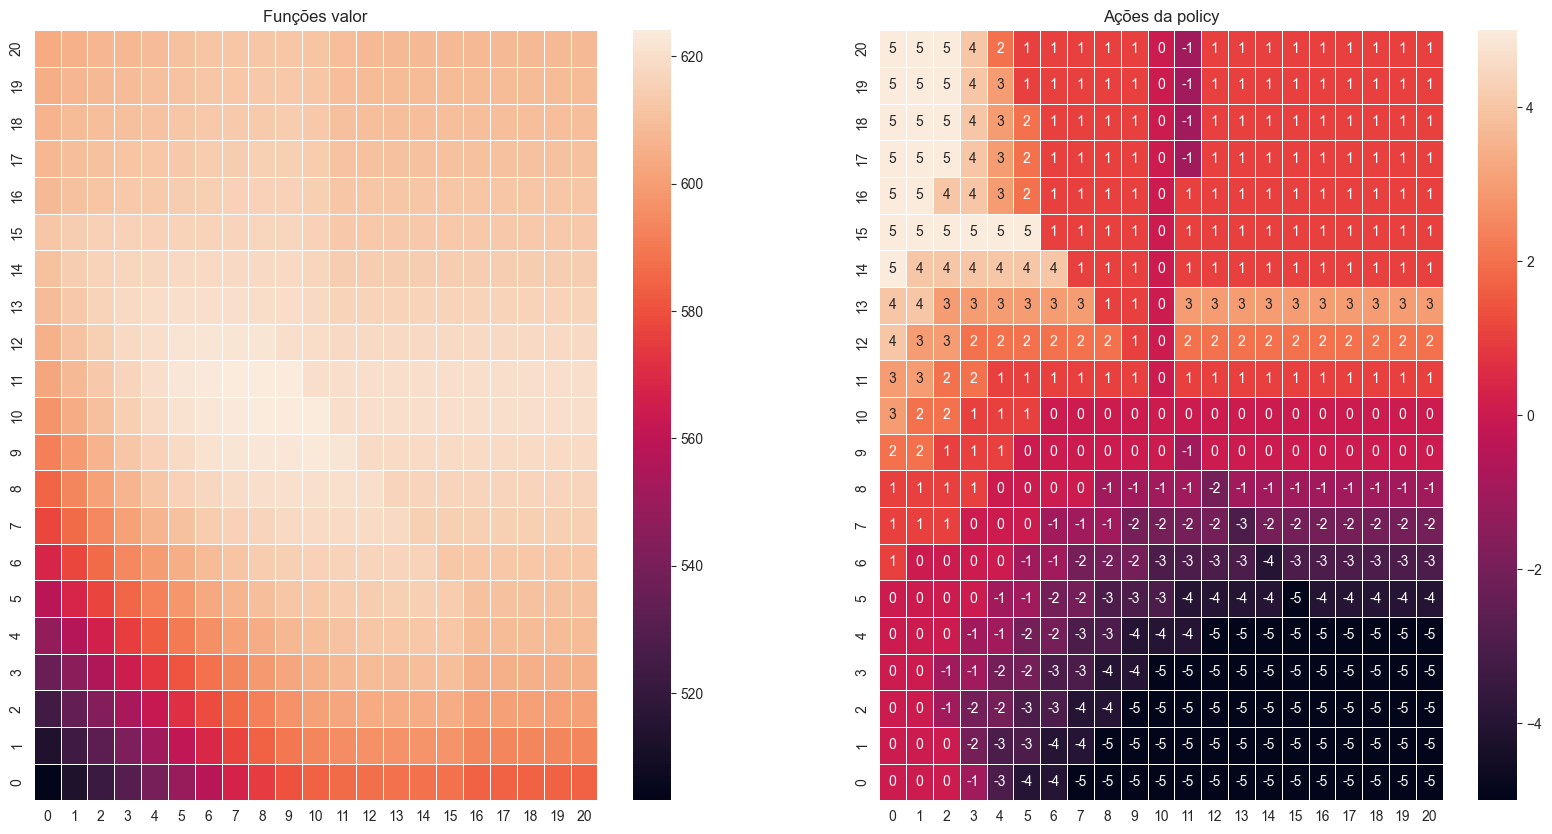

In [51]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(values, linewidths=0.5, ax=ax1)
ax1.set_title("Funções valor")
ax1.invert_yaxis()

sns.heatmap(ideal_p, linewidths=0.5, annot=True, ax=ax2)
ax2.set_title("Ações da policy")
ax2.invert_yaxis()

In [52]:
ideal_p = iterate(env, values, ideal_p, 0.01)

Delta: 0.00764705809018551, Theta: 0.01
Improving policy ...


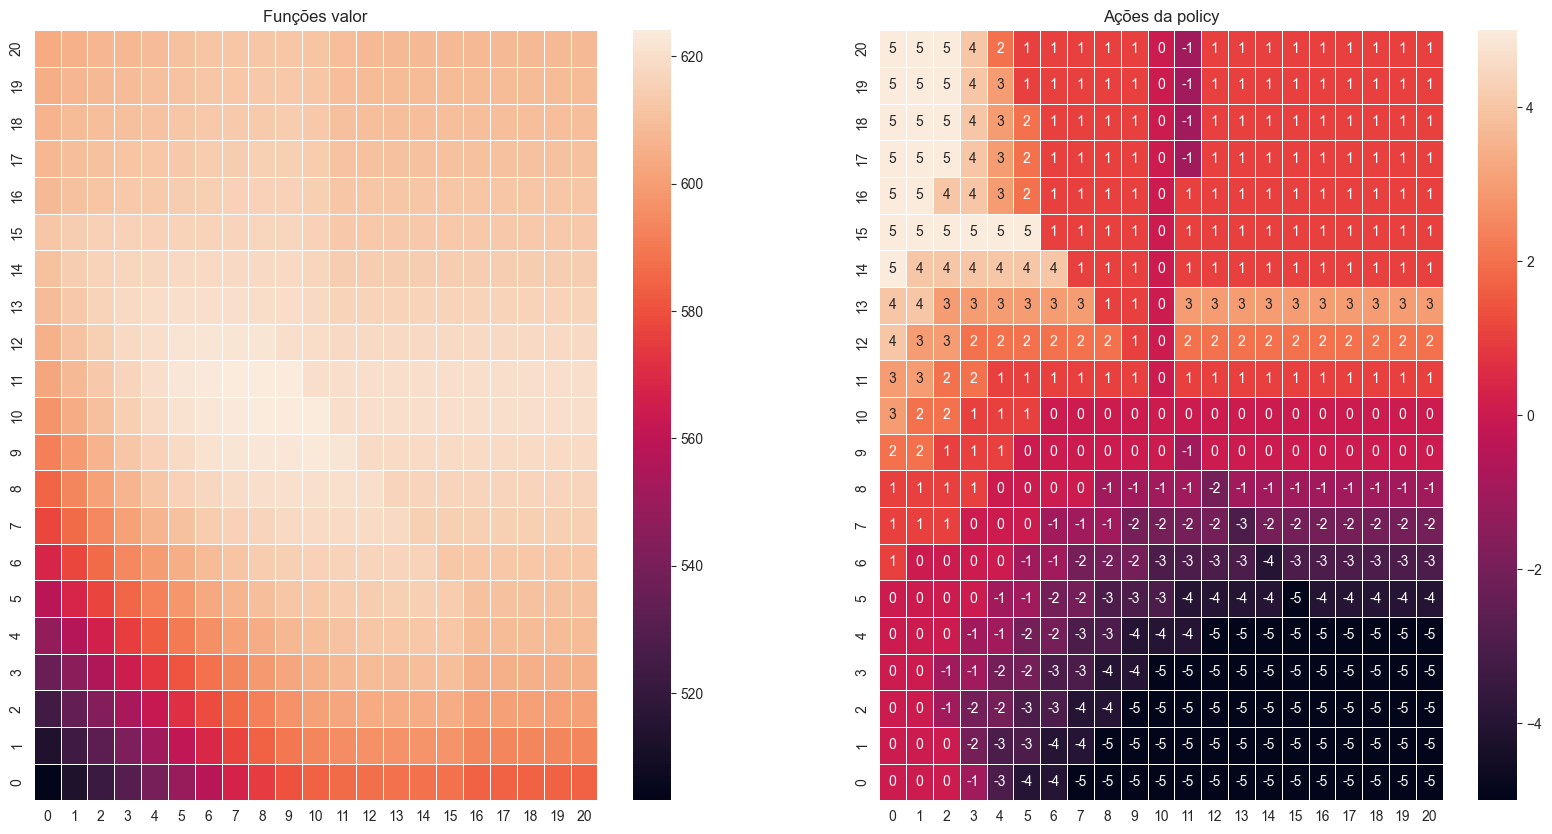

In [53]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(values, linewidths=0.5, ax=ax1)
ax1.set_title("Funções valor")
ax1.invert_yaxis()

sns.heatmap(ideal_p, linewidths=0.5, annot=True, ax=ax2)
ax2.set_title("Ações da policy")
ax2.invert_yaxis()